In [1]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def load_data(data_file):
    data = pd.read_csv(data_file)

    # Extract pixels and emotions
    pixels = data['pixels'].tolist()
    emotions = pd.get_dummies(data['emotion']).to_numpy()

    # Convert pixels to 3D array and add channel dimension
    faces = np.array([np.fromstring(pixel_sequence, dtype=int, sep=' ').reshape(48, 48) for pixel_sequence in pixels])
    faces = np.expand_dims(faces, axis=-1)

    return faces, emotions

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import OneHotEncoder

class CustomDataset(Dataset):
    def __init__(self, data_file, reshape=True, dtype=torch.float32, seed=None):
        self.data = pd.read_csv(data_file)
        self.images = self.data['pixels'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape(48, 48))
        self.labels = self.data['emotion'].values.reshape(-1, 1)

        if reshape:
            self.images = np.stack(self.images).reshape(-1, 48*48)

        self.labels = OneHotEncoder(sparse=False).fit_transform(self.labels)
        self.images = torch.tensor(self.images, dtype=dtype) / 255.0
        self.labels = torch.tensor(self.labels, dtype=dtype)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


In [8]:
import collections
import numpy as np
import pandas as pd
from tensorflow.python.framework import dtypes, random_seed

train_data = "/content/drive/MyDrive/CV/fer2013.csv"

In [9]:
dataset = CustomDataset(train_data)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Splitting into training and remaining sets
train_data, remaining_data = train_test_split(dataset, test_size=(val_ratio + test_ratio))

# Splitting remaining set into validation and test sets
val_data, test_data = train_test_split(remaining_data, test_size=test_ratio / (val_ratio + test_ratio))

# Create DataLoader objects for training, validation, and test sets
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=4608, hidden_size=128, num_layers=1, batch_first=True)

        # Attention layer: compute correlation, attention distribution, and weighted average of hidden states
        self.query_vector = nn.Parameter(torch.randn(128))  # Assume query vector is a learnable parameter

        # Classification layer
        self.classification_layer = nn.Linear(128, 7)  # 128 is the dimension of the context vector, 7 is the number of target classes
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Adjust input tensor shape
        x = x.view(-1, 1, 48, 48)

        # Convolutional and pooling layers
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool3(x)

        # Flatten tensor for LSTM layer
        x = x.view(x.size(0), -1)

        # LSTM part
        x, _ = self.lstm(x.unsqueeze(1))

        # Attention layer
        query_vector = self.query_vector.unsqueeze(0).expand(x.size(0), -1)
        correlation_scores = torch.bmm(x, query_vector.unsqueeze(2)).squeeze(2)  # Dot product correlation
        attention_distribution = F.softmax(correlation_scores, dim=1)  # Attention distribution
        context_vector = torch.bmm(attention_distribution.unsqueeze(1), x).squeeze(1)  # Weighted average of hidden state

        # Classification layer and softmax layer
        x = self.classification_layer(context_vector)
        x = self.softmax(x)

        return x

In [66]:
model = CNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, torch.argmax(labels, dim=1))  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

    # Validate the model
    model.eval()  # Set model to evaluation mode
    val_losses = []
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to device
            outputs = model(images)  # Forward pass
            val_loss = criterion(outputs, torch.argmax(labels, dim=1))  # Compute the loss
            val_losses.append(val_loss.item())
            val_predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_true_labels.extend(torch.argmax(labels, dim=1).cpu().numpy())

    # Calculate validation accuracy
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    # Print epoch information
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {loss.item():.4f}, '
          f'Validation Loss: {sum(val_losses)/len(val_losses)}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/100], Training Loss: 1.9012, Validation Loss: 1.8685830203739144, Validation Accuracy: 0.2686
Epoch [2/100], Training Loss: 1.8239, Validation Loss: 1.786194900083824, Validation Accuracy: 0.3836
Epoch [3/100], Training Loss: 1.7412, Validation Loss: 1.7604738135309614, Validation Accuracy: 0.3959
Epoch [4/100], Training Loss: 1.7592, Validation Loss: 1.740753511705342, Validation Accuracy: 0.4217
Epoch [5/100], Training Loss: 1.7609, Validation Loss: 1.7338019609451294, Validation Accuracy: 0.4232
Epoch [6/100], Training Loss: 1.7276, Validation Loss: 1.7238835653609779, Validation Accuracy: 0.4371
Epoch [7/100], Training Loss: 1.5919, Validation Loss: 1.7156075126320653, Validation Accuracy: 0.4382
Epoch [8/100], Training Loss: 1.7042, Validation Loss: 1.7071879319185337, Validation Accuracy: 0.4553
Epoch [9/100], Training Loss: 1.6474, Validation Loss: 1.6999454519452428, Validation Accuracy: 0.4605
Epoch [10/100], Training Loss: 1.6439, Validation Loss: 1.694844486445365, 

In [ ]:
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, transform):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Get the available device

    # Move the input tensor to the appropriate device
    image_tensor = image_tensor.to(device)

    # Set the model to evaluation mode
    model.eval()

    # Move the model to the appropriate device
    model = model.to(device)

    # Perform the prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = predicted.item()

    # Display the image and predicted class
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted class: {predicted_class}')
    plt.show()


In [ ]:
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']

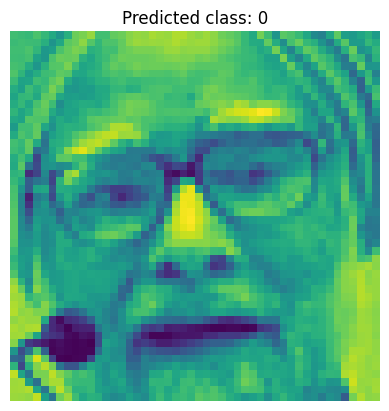

In [ ]:
image = "/content/drive/MyDrive/COSC5470/angry2.jpeg"
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
predict_image(model, image, transform)